### 1

제주도 부동산 실거래가 데이터(CSV)를 Pandas로 로드하고,
모델링에 적합하도록 데이터 정제(결측치, 타입 변환) 및 특성 공학(거래일로부터 연/월 추출, 면적 단위 통일 등)을 수행

In [1]:
import pandas as pd
# 2021년 1월 ~ 2025년 7월 9일까지의 데이터
df0 = pd.read_csv('아파트_매매_실거래가_2021.csv',encoding="utf-8")
df1 = pd.read_csv('아파트_매매_실거래가_2021_2022.csv', encoding="utf-8")
df2 = pd.read_csv('아파트_매매_실거래가_2022_2023.csv', encoding="utf-8")
df3 = pd.read_csv('아파트_매매_실거래가_2023_2024.csv', encoding="utf-8")
df4 = pd.read_csv('아파트_매매_실거래가_2024_2025.csv', encoding="utf-8")
df = pd.concat([df0, df1, df2, df3, df4])
print(df)

# 필요한 컬럼만 뽑기
df = df[['시군구', '전용면적(㎡)', '계약년월', '계약일' , '거래금액(만원)', '건축년도']]

# 거래금액의 쉼표(,) 제거 후 숫자 타입 변환
# print(df.dtypes)
df['거래금액'] = df['거래금액(만원)'].str.replace(',', '').astype('int')*10000
df = df.drop('거래금액(만원)', axis=1)

# 계약년월에서 '년', '월' 파생변수 생성
df['계약년도'] = df['계약년월']//100
df['계약월'] = df['계약년월']%100
df['계약년월'] = pd.to_datetime(df['계약년월'].astype(str), format='%Y%m') # 년-월 형태로 변경
df['계약년월'] = df['계약년월'].dt.to_period('M')
print(df.head(5))

# '시'컬럼 생성(제주시/서귀포시)
df['시'] = df['시군구'].str.split(' ').str[1]
df = df.drop('시군구', axis=1)

# 결측치확인
print(df.isna().sum()) # 결측값 없음
df.head(5)

# 정제된 데이터 jeju_real_estate_cleaned.csv로 저장
df.to_csv('jeju_real_estate_cleaned.csv', index=False)

        NO                   시군구      번지    본번  부번                   단지명  \
0        1      제주특별자치도 서귀포시 하원동   367-1   367   1                    서진   
1        2      제주특별자치도 제주시 일도이동    47-1    47   1                 일도신천지   
2        3   제주특별자치도 제주시 애월읍 애월리    1622  1622   0                혁승애월다움   
3        4      제주특별자치도 서귀포시 동홍동   355-1   355   1            주공4(동홍주공4)   
4        5      제주특별자치도 서귀포시 서귀동  202-21   202  21               바원에스클래스   
...    ...                   ...     ...   ...  ..                   ...   
2377  2378      제주특별자치도 서귀포시 강정동     195   195   0    서귀포강정지구3블럭중흥에스-클래스   
2378  2379  제주특별자치도 서귀포시 대정읍 동일리    3172  3172   0                 모슬포라움   
2379  2380       제주특별자치도 제주시 노형동  1273-6  1273   6                    연동   
2380  2381      제주특별자치도 서귀포시 중문동  2433-2  2433   2               중문미듬하나로   
2381  2382      제주특별자치도 서귀포시 서홍동   299-1   299   1  태봉그린피아(101,102,103동)   

      전용면적(㎡)    계약년월  계약일 거래금액(만원)            동  층 매수자 매도자  건축년도  \
0     49.8737  202

### 2
정제된 데이터를 사용하여 제주시/서귀포시 등 지역별, 전용면적 구간별 평당(또는 제곱미터당) 가격의 평균을 계산하고, 시간(연/월)에 따른 가격 변화 추이를 선 그래프 등으로 시각화하여 분석

In [9]:
import matplotlib.pyplot as plt

# 한글 깨짐 방지(나눔고딕)
plt.rcParams['font.family'] = 'NanumGothic'

# 1. '평당가격' 파생 컬럼 생성
df = pd.read_csv('jeju_real_estate_cleaned.csv', encoding="utf-8")
df['평'] = df['전용면적(㎡)'] * 0.3025
df['평당가격'] = df['거래금액']//df['평']

# 2. 서귀포시/제주시 지역별 계약년월별 평균 '평당가격' 계산
new_df = df.groupby(['시', '계약년월'])['평당가격'].mean().reset_index()
print(new_df)

# 3. 전용면적을 특정구간별로 나누고 각 구간별 연도별 평균 '평당가격' 계산
# 65㎡미만, 65㎡이상~99㎡미만, 99㎡이상~135㎡미만, 135㎡이상~165㎡미만, 165㎡초과
# 전용면적을 구간별로 나누기
bins = [0, 65, 99, 135, 165, float('inf')]
labels = ['65㎡미만', '65㎡이상~99㎡미만', '99㎡이상~135㎡미만', '135㎡이상~165㎡미만', '165㎡초과']  # 구간 레이블
df['구간'] = pd.cut(df['전용면적(㎡)'], bins=bins, labels=labels, right=False)

# 연도별로 구간과 '평당가격' 평균 계산
grouped_df = df.groupby(['구간', '계약년월'])['평당가격'].mean().reset_index()
print(grouped_df)
grouped_df.isna().sum() # 구간으로 나눴을 때 평당가격이 없는 case 존재 -> 거래가 없었음. (평수가 넓은 부동산일수록 거래량이 적거나 없기도 함)

        시     계약년월          평당가격
0    서귀포시  2021-01  1.106325e+07
1    서귀포시  2021-02  1.221292e+07
2    서귀포시  2021-03  1.225415e+07
3    서귀포시  2021-04  1.235445e+07
4    서귀포시  2021-05  1.211739e+07
..    ...      ...           ...
105   제주시  2025-03  1.629049e+07
106   제주시  2025-04  1.620089e+07
107   제주시  2025-05  1.604557e+07
108   제주시  2025-06  1.688722e+07
109   제주시  2025-07  1.688416e+07

[110 rows x 3 columns]
         구간     계약년월          평당가격
0     65㎡미만  2021-01  1.230063e+07
1     65㎡미만  2021-02  1.372177e+07
2     65㎡미만  2021-03  1.344490e+07
3     65㎡미만  2021-04  1.587618e+07
4     65㎡미만  2021-05  1.487764e+07
..      ...      ...           ...
270  165㎡초과  2025-03           NaN
271  165㎡초과  2025-04           NaN
272  165㎡초과  2025-05           NaN
273  165㎡초과  2025-06           NaN
274  165㎡초과  2025-07           NaN

[275 rows x 3 columns]


구간       0
계약년월     0
평당가격    48
dtype: int64

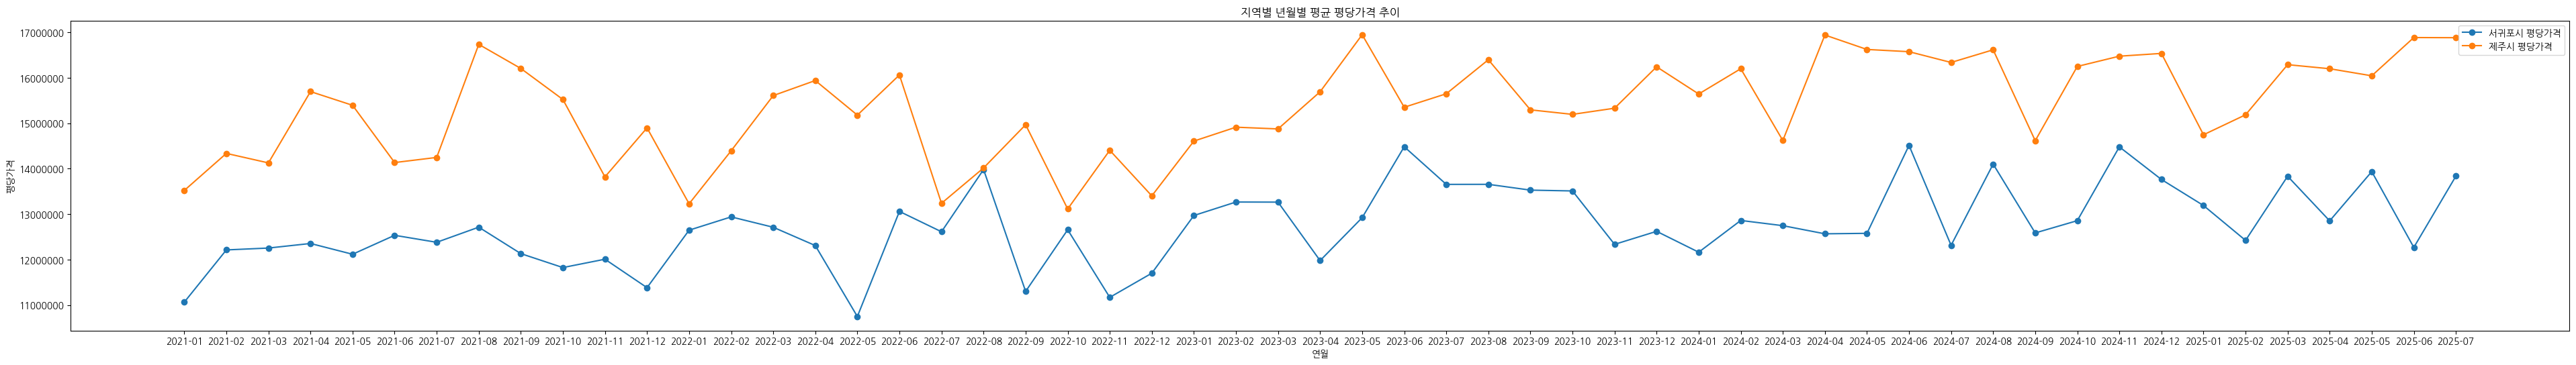

In [3]:
# 4. 2와 3의 결과를 선 그래프로 시각화하여 가격 추이 확인
#2번 결과: 지역별 연도별 평균 '평당가격' 시각화
plt.figure(figsize=(48, 6))
for city in new_df['시'].unique():
    city_data = new_df[new_df['시'] == city]
    plt.plot(city_data['계약년월'], city_data['평당가격'], label=f'{city} 평당가격', marker='o')

plt.title('지역별 년월별 평균 평당가격 추이')
plt.xlabel('연월')
plt.ylabel('평당가격')
plt.ticklabel_format(style='plain', axis='y')  # 지수표기법 비활성화
plt.legend(loc='best', bbox_to_anchor=(1.0,1.0))
plt.show()

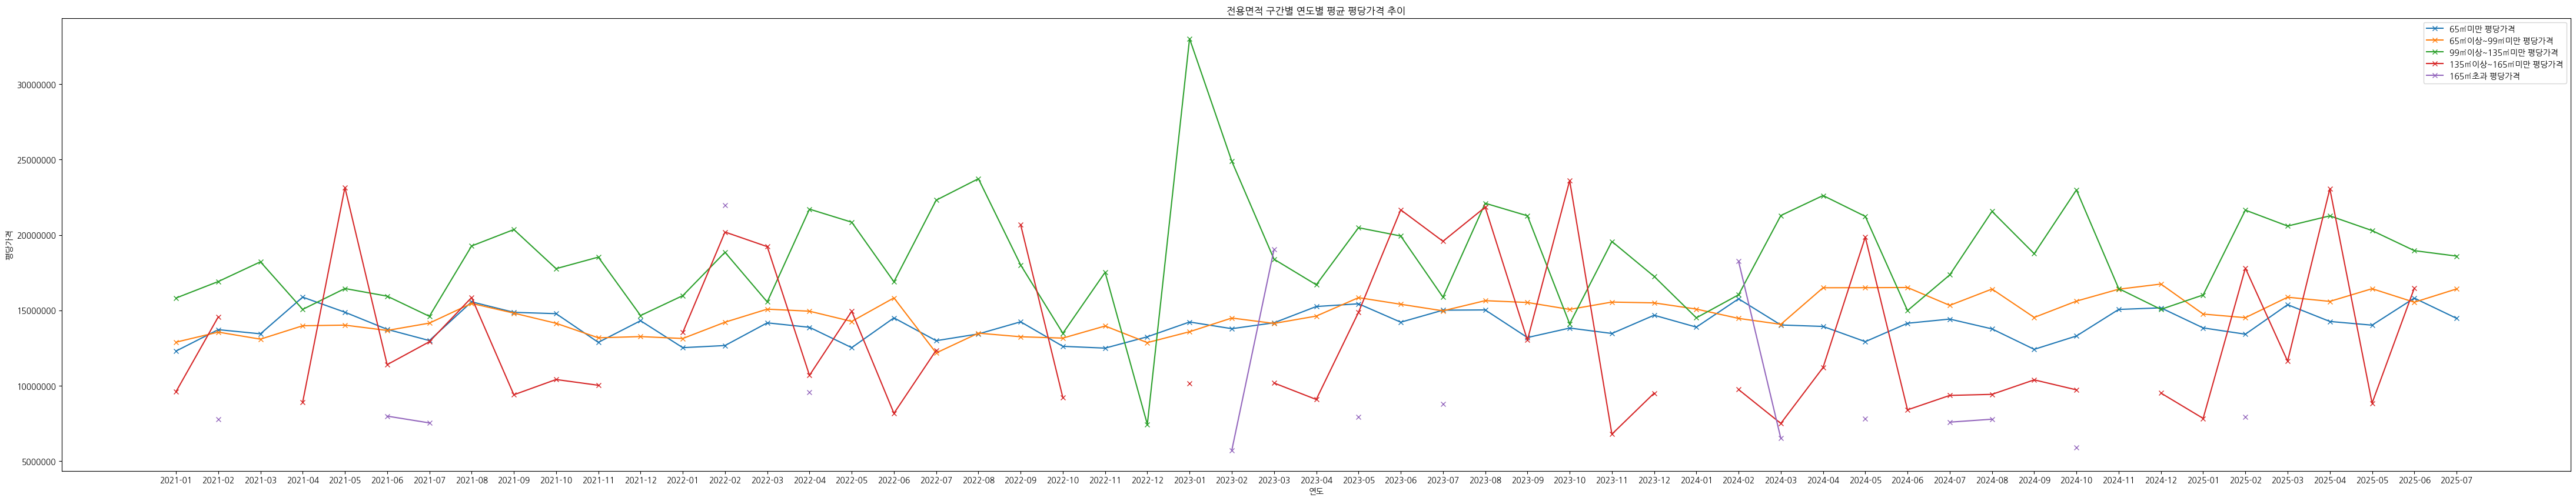

In [10]:
# 3번 결과: 전용면적 구간별 연도별 평균 '평당가격'
plt.figure(figsize=(55, 10))
for label in labels:
    segment_data = grouped_df[grouped_df['구간'] == label]
    plt.plot(segment_data['계약년월'], segment_data['평당가격'], label=f'{label} 평당가격', marker='x')

plt.title('전용면적 구간별 연도별 평균 평당가격 추이')
plt.xlabel('연도')
plt.ylabel('평당가격')
plt.ticklabel_format(style='plain', axis='y')  # 지수표기법 비활성화
plt.legend(loc='best')
plt.show()

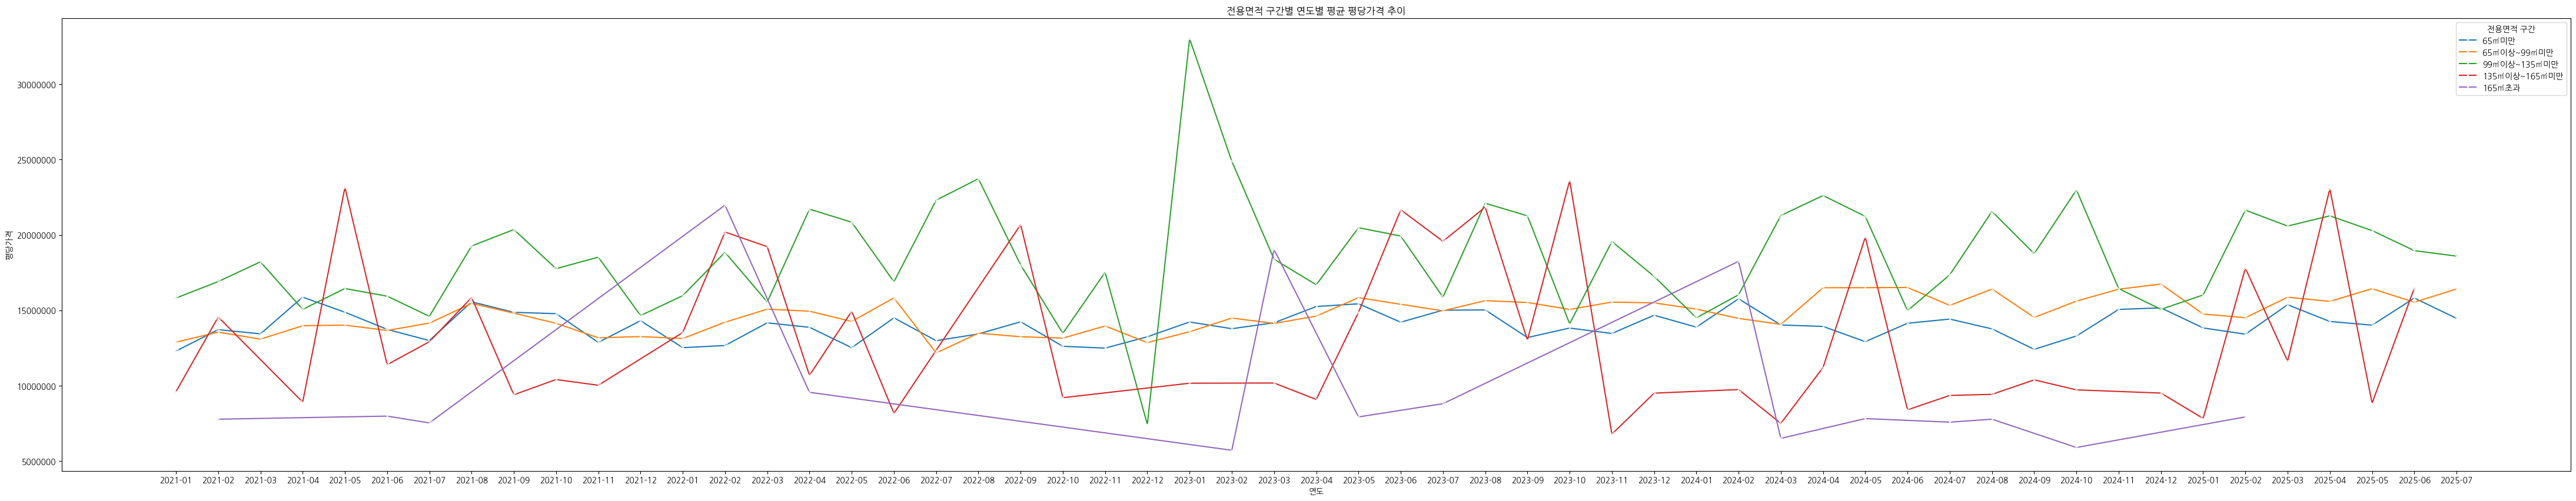

In [11]:
import seaborn as sns

# 시각화
plt.figure(figsize=(55, 10))

# seaborn을 이용한 꺾은선 그래프
sns.lineplot(data=grouped_df, x='계약년월', y='평당가격', hue='구간', marker='x')

plt.title('전용면적 구간별 연도별 평균 평당가격 추이')
plt.xlabel('연도')
plt.ylabel('평당가격')
plt.ticklabel_format(style='plain', axis='y')  # 지수표기법 비활성화
plt.legend(title='전용면적 구간', loc='best')

plt.show()


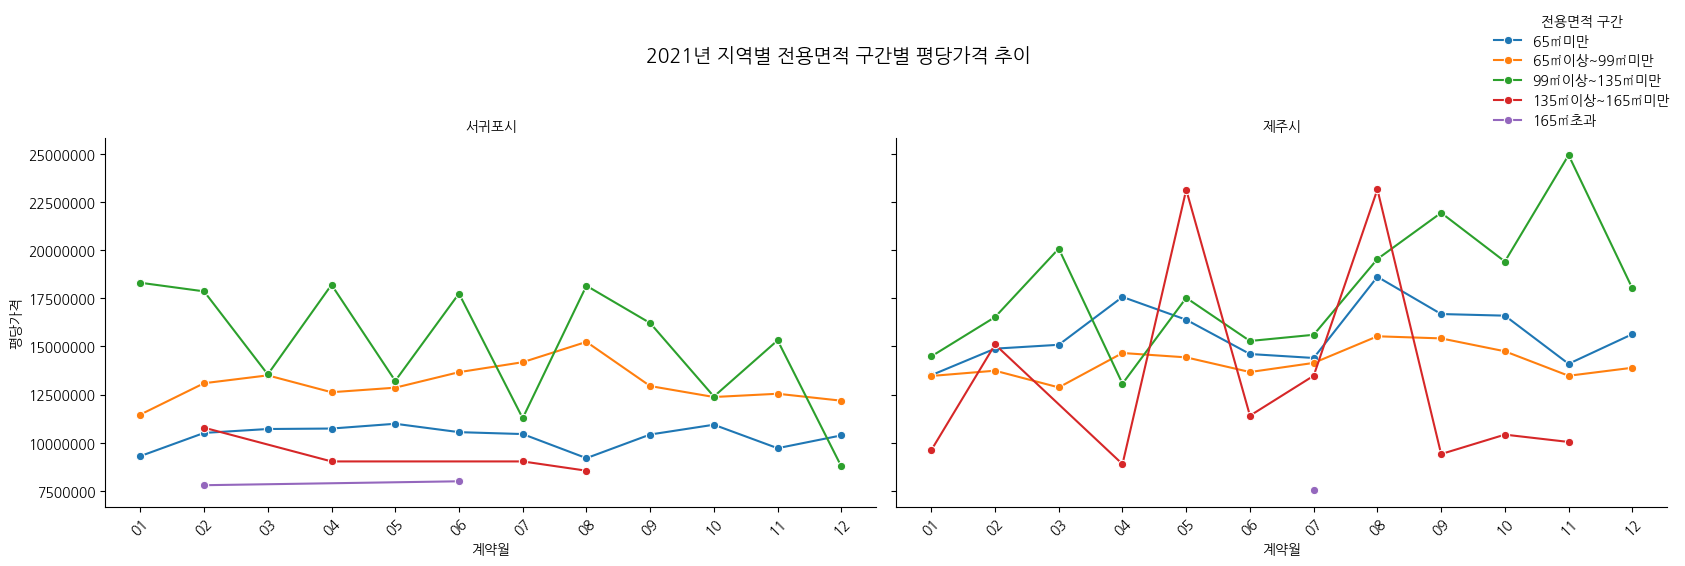

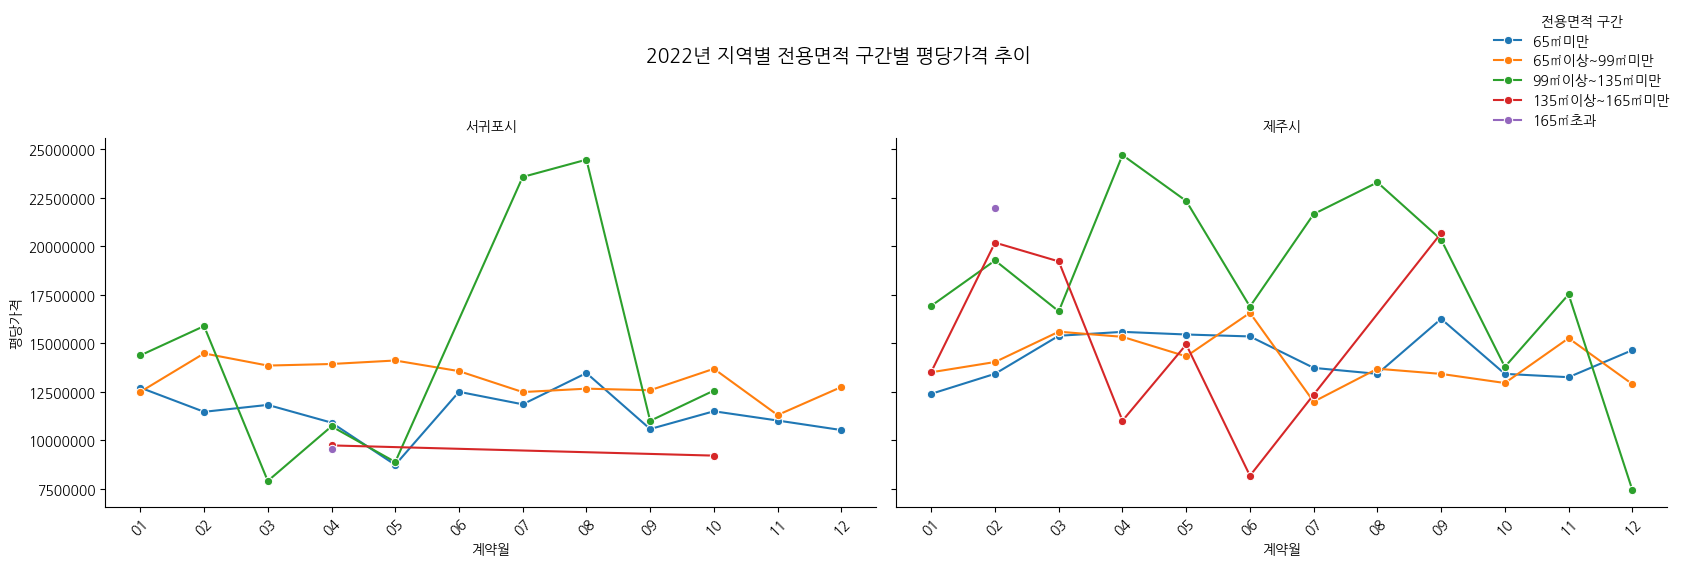

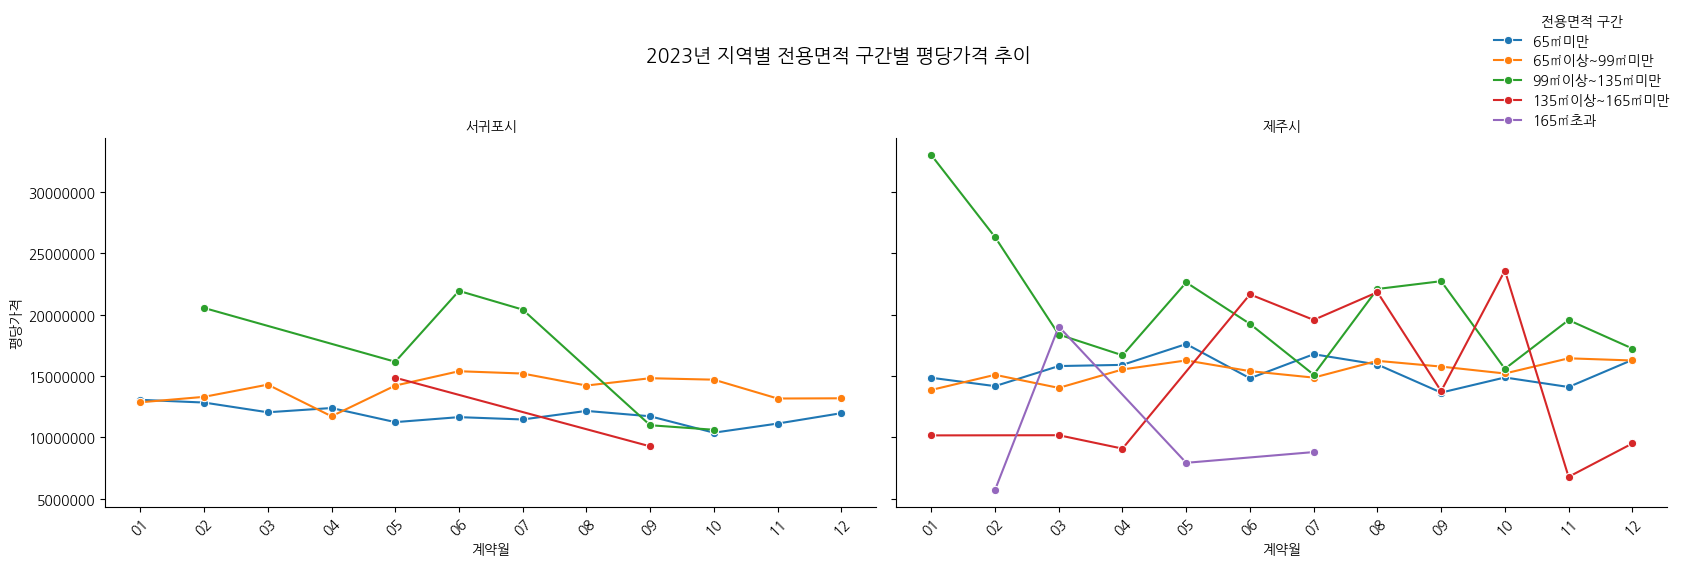

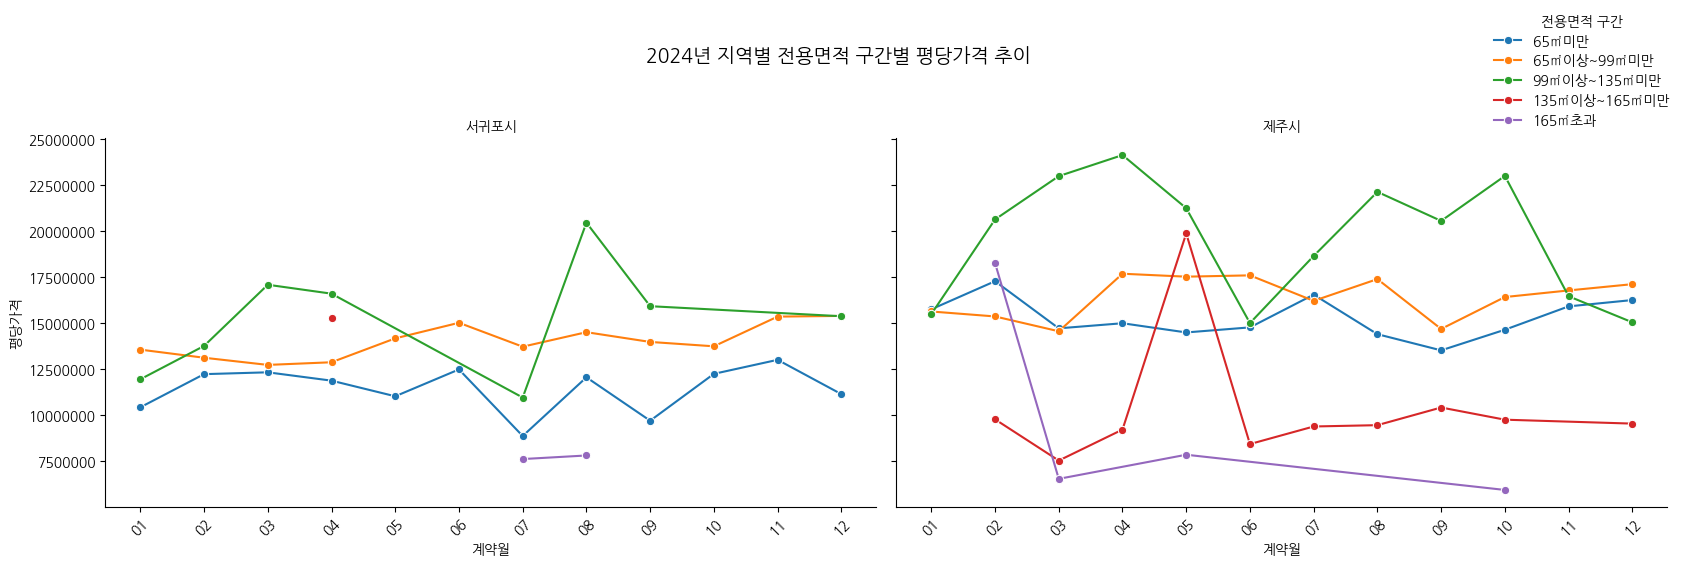

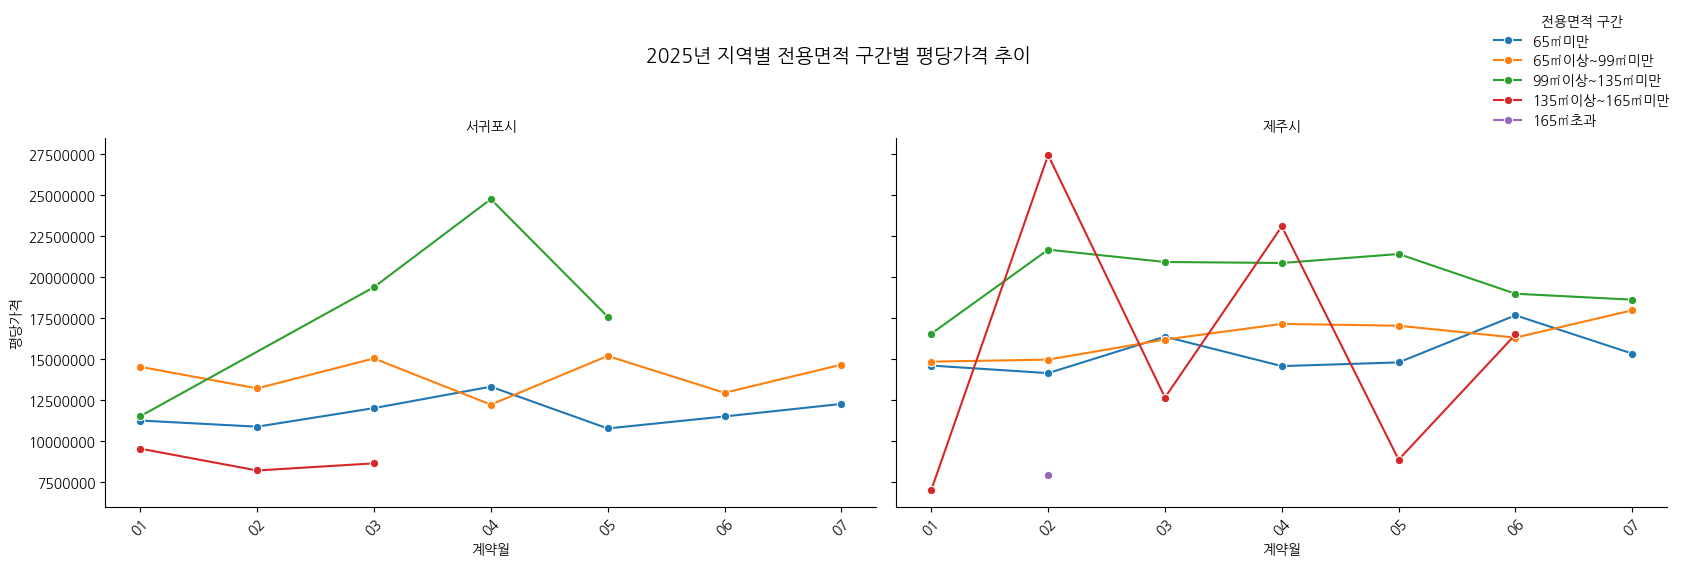

In [23]:
import warnings # 경고 삭제
warnings.filterwarnings("ignore", category=UserWarning)

import seaborn as sns
import matplotlib.pyplot as plt

grouped_df = df.groupby(['구간', '계약년월', '시'])['평당가격'].mean().reset_index()

# '계약년도', '계약월' 컬럼 생성
grouped_df['계약년도'] = grouped_df['계약년월'].astype(str).str[:4]
grouped_df['계약월'] = grouped_df['계약년월'].astype(str).str[5:]

# 연도별로 지역도 구분하여 시각화
for year in sorted(grouped_df['계약년도'].unique()):
    year_data = grouped_df[grouped_df['계약년도'] == year]

    g = sns.FacetGrid(year_data, col='시', hue='구간', height=5, aspect=1.5)
    g.map(sns.lineplot, '계약월', '평당가격', marker='o')

    for ax in g.axes.flat:
        ax.ticklabel_format(style='plain', axis='y')  # 지수표기법 비활성화
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # x축 월 라벨 회전

    g.add_legend(title='전용면적 구간', bbox_to_anchor=(1.0,1.0))
    g.set_axis_labels("계약월", "평당가격")
    g.set_titles(col_template="{col_name}")
    plt.suptitle(f"{year}년 지역별 전용면적 구간별 평당가격 추이", fontsize=14, y=1.05)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


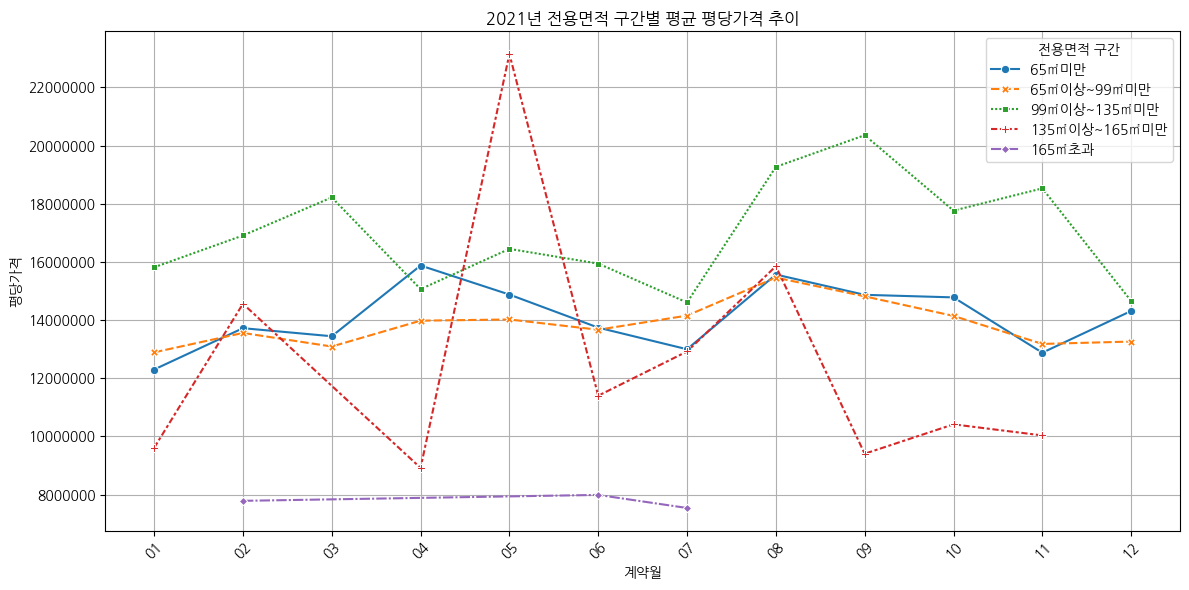

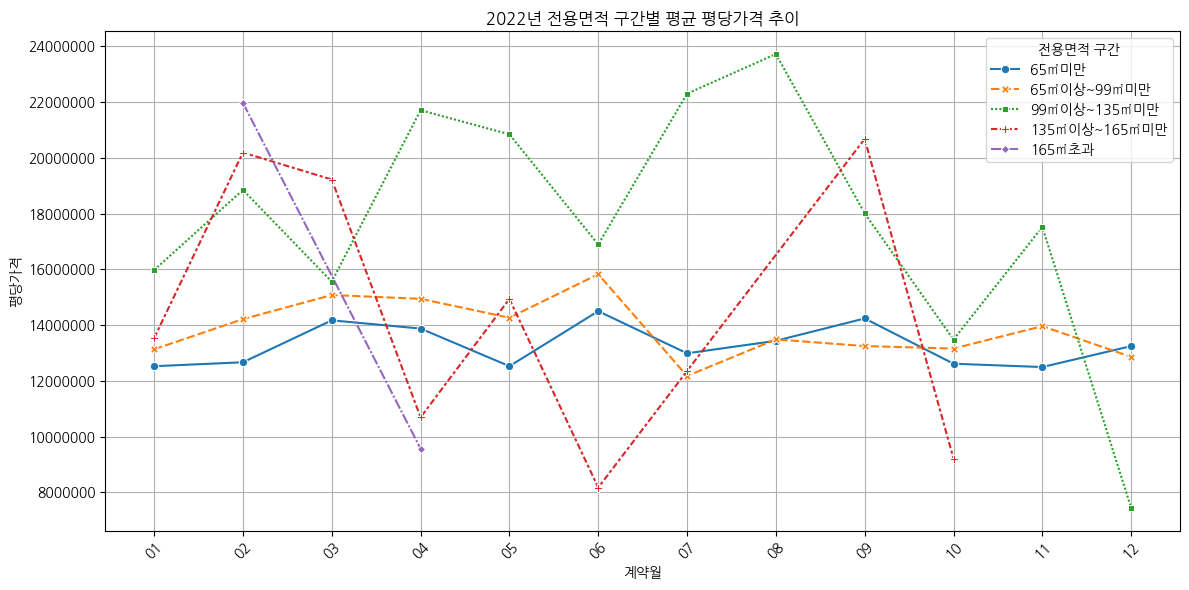

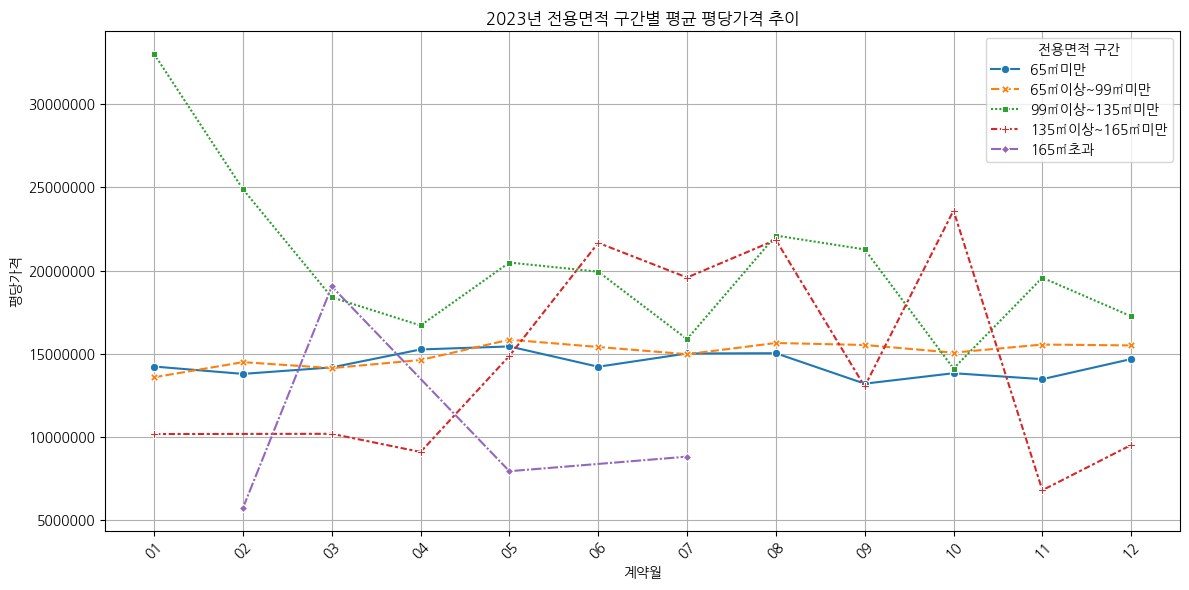

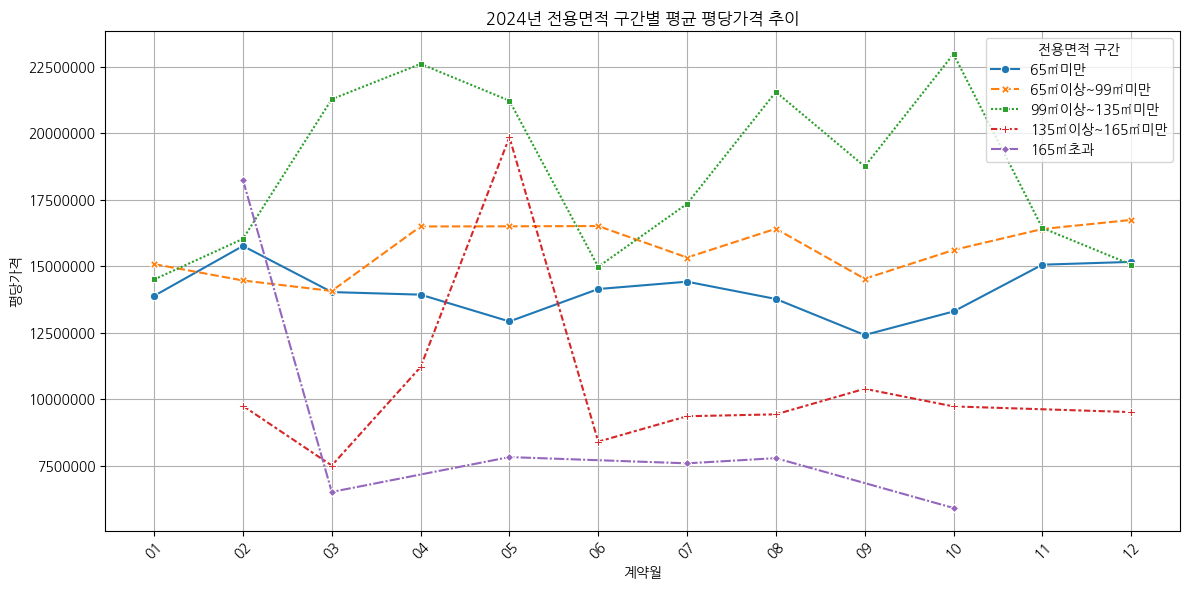

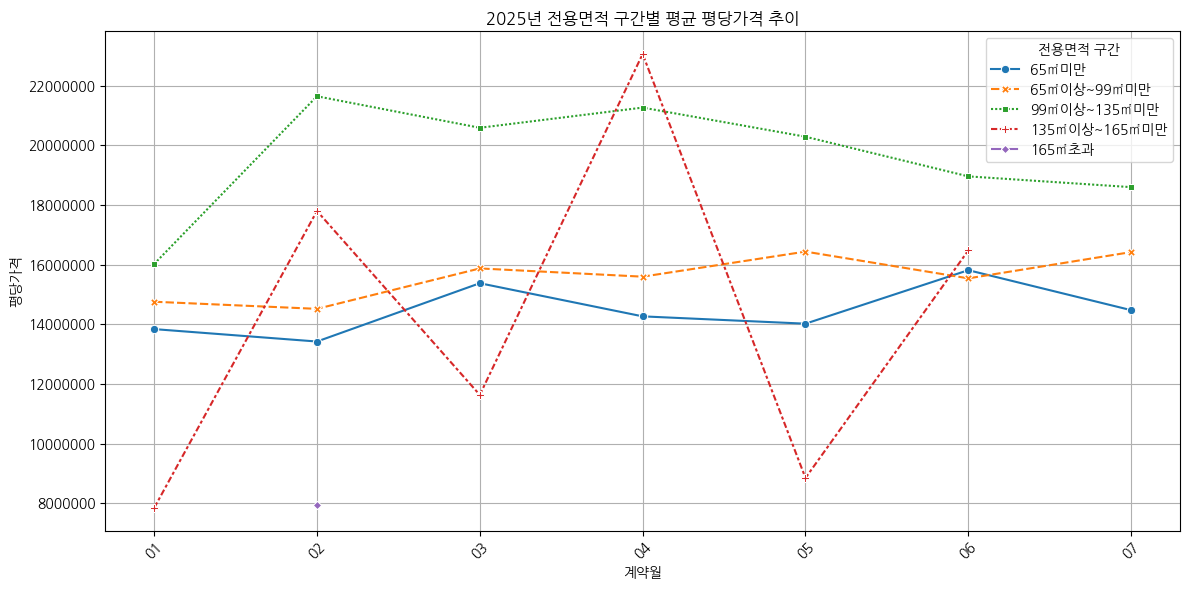

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped_df = df.groupby(['구간', '계약년월'])['평당가격'].mean().reset_index()

# '계약년도' 컬럼 생성
grouped_df['계약년도'] = grouped_df['계약년월'].str[:4]
grouped_df['계약월'] = grouped_df['계약년월'].str[5:]  # x축에 월만 사용하려면

# 연도별로 시각화
for year in sorted(grouped_df['계약년도'].unique()):
    plt.figure(figsize=(12, 6))
    
    year_data = grouped_df[grouped_df['계약년도'] == year]

    # 각 구간별로 꺾은선 그래프
    sns.lineplot(data=year_data, x='계약월', y='평당가격', hue='구간', style='구간', markers=True)
    plt.title(f'{year}년 전용면적 구간별 평균 평당가격 추이')
    plt.xlabel('계약월')
    plt.ylabel('평당가격')
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='전용면적 구간', loc='best')
    plt.tight_layout()
    plt.show()


### 3

전처리된 데이터 바탕으로 특정 부동산의 가격 예측하는 회귀모델(선형회귀, 랜덤포레스트 등)을 사이킷런을 통해 구축하고, 모델의 성능을 평가해 어떤 특성이 가격 예측에 중요한 영향을 미치는지 확인

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# 거래금액을 타겟(y)으로, 나머지(지역, 면적, 계약년월)를 특성(x)으로 설정.
df = pd.read_csv('jeju_real_estate_cleaned.csv', encoding='utf-8')
target = df['거래금액']
x = df.loc[:, df.columns != '거래금액']
x = x.drop(['계약년월', '계약일'], axis=1)
x_town = x[['시']]

# 지역 등 범주형 특성 원 핫 인코딩
# display(x.dtypes)
# onehot = OneHotEncoder(sparse=False)

# ohe_encoded = onehot.fit_transform(x_town)
# ohe_df = pd.DataFrame(ohe_encoded, columns=onehot.get_feature_names_out(['시'])) # 원 핫 인코딩된 결과를 DataFrame으로 변환
# # 원 핫 인코딩 결과를 기존 특성과 결합
# x = x.drop('시', axis=1)  # '시' 컬럼은 제거
# x = pd.concat([x, ohe_df], axis=1)

# 지역 등 범주형 특성 라벨 인코딩
le = LabelEncoder()
x['시'] = le.fit_transform(x['시'])
x['시'].head(10)

print("원핫인코딩, RMSE: 48464254.366223566 R²: 0.9267870135780276")
print("라벨인코딩, RMSE: 48277255.156859875 R²: 0.9273509078482283")

# 데이터를 학습/테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

# RandomForestRegressor 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # 예측

# 테스트 데이터에 대한 RMSE 및 R² 점수 계산 및 출력
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# 학습된 모델의 특성 중요도 상위 5개 출력.
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # 중요도에 따라 내림차순 정렬
print("\n상위 5개 특성 중요도:")
for f in range(5):
    print(f"{f + 1}. {x.columns[indices[f]]}: {feature_importances[indices[f]]}")

원핫인코딩, RMSE: 48464254.366223566 R²: 0.9267870135780276
라벨인코딩, RMSE: 48277255.156859875 R²: 0.9273509078482283
RMSE: 48277255.156859875
R²: 0.9273509078482283

상위 5개 특성 중요도:
1. 전용면적(㎡): 0.68519040383616
2. 건축년도: 0.2347314743294092
3. 시: 0.030533134959835548
4. 계약월: 0.02701946972085715
5. 계약년도: 0.022525517153738128
